[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture8_learning_juntas.ipynb)

# Lecture 8: Learning Juntas

**Topics**: Junta testing, Junta learning, Relevant variables

**References**: [Mossel-O'Donnell-Servedio'04], [Valiant'12]  
**Based on lecture notes by: Timothe Kasriel**  
**Notebook by: Gabriel Taboada**

---

## Key Concepts

| Term | Definition |
|------|------------|
| **k-Junta** | Function depending on **at most** $k$ variables |
| **Relevant variable** | Variable $i$ where $\text{Inf}_i[f] > 0$ |
| **Junta Testing** | Determine if $f$ is close to a $k$-junta |
| **Junta Learning** | Learn *which* $k$ variables matter |

In [1]:
# Install/upgrade boofun (required for Colab)
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf

import warnings
warnings.filterwarnings('ignore')

---
## 1. What is a Junta?

**Definition**: A Boolean function $f: \{\pm 1\}^n \to \{\pm 1\}$ is a **$k$-junta** if it depends on at most $k$ of its $n$ input variables.

Equivalently, there exists a set $J \subseteq [n]$ with $|J| \leq k$ such that $f(x)$ only depends on $(x_i)_{i \in J}$.

**Key insight**: A variable $i$ is *relevant* if and only if $\text{Inf}_i[f] > 0$.

In [3]:
# Example 1: Dictator is a 1-junta
n = 8
dictator = bf.dictator(n, 0)  # f(x) = x_0

print("Example 1: Dictator function (n=8)")
print("="*50)
print(f"f(x) = x_0")
print(f"\nInfluences: {[f'{inf:.4f}' for inf in dictator.influences()]}")
print(f"Relevant variables: variable 0 only")
print(f"\nis_junta(1): {dictator.is_junta(1)}")
print(f"is_junta(2): {dictator.is_junta(2)}  (1-junta is also a 2-junta)")

Example 1: Dictator function (n=8)
f(x) = x_0

Influences: ['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Relevant variables: variable 0 only

is_junta(1): True
is_junta(2): True  (1-junta is also a 2-junta)


In [4]:
# Example 2: Parity is a k-junta (depends on exactly k variables)
parity_3 = bf.parity(3)  # XOR of 3 variables, embedded in n=3

print("Example 2: Parity-3 function")
print("="*50)
print(f"f(x) = x_0 ⊕ x_1 ⊕ x_2")
print(f"\nInfluences: {[f'{inf:.4f}' for inf in parity_3.influences()]}")
print(f"All variables have equal influence = 1.0")
print(f"\nis_junta(2): {parity_3.is_junta(2)}  (needs all 3 variables)")
print(f"is_junta(3): {parity_3.is_junta(3)}")

Example 2: Parity-3 function
f(x) = x_0 ⊕ x_1 ⊕ x_2

Influences: ['1.0000', '1.0000', '1.0000']
All variables have equal influence = 1.0

is_junta(2): False  (needs all 3 variables)
is_junta(3): True


In [5]:
# Example 3: Majority needs ALL variables
maj7 = bf.majority(7)

print("Example 3: Majority-7 function")
print("="*50)
print(f"f(x) = sign(x_0 + x_1 + ... + x_6)")
print(f"\nInfluences: {[f'{inf:.4f}' for inf in maj7.influences()]}")
print(f"All 7 variables have positive influence!")
print(f"\nis_junta(3): {maj7.is_junta(3)}  ← NOT a 3-junta")
print(f"is_junta(6): {maj7.is_junta(6)}  ← NOT a 6-junta")
print(f"is_junta(7): {maj7.is_junta(7)}  ← IS a 7-junta")
print(f"\nMajority-7 depends on ALL 7 variables, so it's exactly a 7-junta.")

Example 3: Majority-7 function
f(x) = sign(x_0 + x_1 + ... + x_6)

Influences: ['0.3125', '0.3125', '0.3125', '0.3125', '0.3125', '0.3125', '0.3125']
All 7 variables have positive influence!

is_junta(3): False  ← NOT a 3-junta
is_junta(6): False  ← NOT a 6-junta
is_junta(7): True  ← IS a 7-junta

Majority-7 depends on ALL 7 variables, so it's exactly a 7-junta.


In [6]:
# Example 4: AND function - also needs all variables
and4 = bf.AND(4)

print("Example 4: AND-4 function")
print("="*50)
print(f"f(x) = x_0 ∧ x_1 ∧ x_2 ∧ x_3")
print(f"\nInfluences: {[f'{inf:.4f}' for inf in and4.influences()]}")
print(f"\nis_junta(3): {and4.is_junta(3)}")
print(f"is_junta(4): {and4.is_junta(4)}")

Example 4: AND-4 function
f(x) = x_0 ∧ x_1 ∧ x_2 ∧ x_3

Influences: ['0.1250', '0.1250', '0.1250', '0.1250']

is_junta(3): False
is_junta(4): True


In [7]:
# Example 5: Create a "hidden" junta - function on n=10 that only uses 3 variables
# f(x) = x_2 XOR x_5 XOR x_8 (a 3-junta hidden in 10 variables)
n = 10

# Build truth table: f depends only on variables 2, 5, 8
truth_table = []
for i in range(2**n):
    # Extract bits at positions 2, 5, 8
    b2 = (i >> 2) & 1
    b5 = (i >> 5) & 1  
    b8 = (i >> 8) & 1
    # XOR of these three bits, mapped to {+1, -1}
    parity = (b2 + b5 + b8) % 2
    truth_table.append(-1 if parity else 1)  # 0 -> +1, 1 -> -1

hidden_junta = bf.create(truth_table)

print("Example 5: Hidden 3-junta in n=10 variables")
print("="*50)
print(f"f(x) = x_2 ⊕ x_5 ⊕ x_8  (only depends on 3 of 10 variables)")
print(f"\nInfluences:")
for i, inf in enumerate(hidden_junta.influences()):
    marker = "← relevant" if inf > 0 else ""
    print(f"  x_{i}: {inf:.4f} {marker}")
print(f"\nis_junta(2): {hidden_junta.is_junta(2)}")
print(f"is_junta(3): {hidden_junta.is_junta(3)}")
print(f"is_junta(10): {hidden_junta.is_junta(10)}")

Example 5: Hidden 3-junta in n=10 variables
f(x) = x_2 ⊕ x_5 ⊕ x_8  (only depends on 3 of 10 variables)

Influences:
  x_0: 0.0000 
  x_1: 0.0000 
  x_2: 1.0000 ← relevant
  x_3: 0.0000 
  x_4: 0.0000 
  x_5: 1.0000 ← relevant
  x_6: 0.0000 
  x_7: 0.0000 
  x_8: 1.0000 ← relevant
  x_9: 0.0000 

is_junta(2): False
is_junta(3): True
is_junta(10): True


---
## 2. Fourier Structure of Juntas

**Key property**: If $f$ is a $k$-junta on variables $J$, then $\hat{f}(S) = 0$ for any $S \not\subseteq J$.

This means all non-zero Fourier coefficients are "supported" on the $k$ relevant variables.

**Corollary**: For a $k$-junta, $\hat{f}(S) \in \{0\} \cup \{\alpha/2^k : \alpha \in \mathbb{Z}\}$ (multiples of $2^{-k}$).

In [8]:
# Visualize Fourier support of a junta
print("Fourier coefficients of the hidden 3-junta:")
print("="*50)
fourier = hidden_junta.fourier()

# Find non-zero coefficients
nonzero = [(s, fourier[s]) for s in range(len(fourier)) if abs(fourier[s]) > 1e-10]
print(f"Non-zero coefficients: {len(nonzero)} out of {len(fourier)}")
print()
for s, coef in nonzero:
    bits = [i for i in range(hidden_junta.n_vars) if (s >> i) & 1]
    print(f"  S={bits}: f̂(S) = {coef:.4f}")

print(f"\nNote: All non-zero coefficients are supported on {{2, 5, 8}}")
print(f"and are multiples of 1/2^3 = 0.125")

Fourier coefficients of the hidden 3-junta:
Non-zero coefficients: 1 out of 1024

  S=[]: f̂(S) = -1.0000

Note: All non-zero coefficients are supported on {2, 5, 8}
and are multiples of 1/2^3 = 0.125


---
## 3. Learning Juntas: Two Algorithms

From [MOS04], there are two complementary approaches:

### Algorithm 1: Low-Degree Algorithm
- Enumerate Fourier coefficients $\hat{f}(S)$ for small $|S|$
- Works well when some small coefficient is non-zero
- Runtime: $O(n^t)$ if there exists $|S| \leq t$ with $\hat{f}(S) \neq 0$

### Algorithm 2: Gaussian Elimination
- Treat the function as a polynomial over $\mathbb{F}_2$
- Solve linear system from random examples
- Runtime: $O(n^{d\omega})$ where $d = \deg_{\mathbb{F}_2}(f)$ and $\omega \approx 2.37$ is matrix multiplication exponent

### The Trade-off (Lemma 8.5)
If $\hat{f}(S) = 0$ for all $|S| < t$, then $\deg_{\mathbb{F}_2}(f) \leq k - t$.

Optimal choice: $t = \frac{\omega}{\omega+1} k$ gives runtime $\approx n^{k\omega/(\omega+1)}$.

In [9]:
# Demonstrate the Low-Degree Algorithm idea
print("Low-Degree Algorithm: Finding relevant variables")
print("="*60)

# For a junta, we can find relevant variables by looking at degree-1 coefficients
# (if the function has any degree-1 Fourier mass)

def find_relevant_via_fourier(f, threshold=0.01):
    """Find relevant variables by examining Fourier coefficients."""
    n = f.n_vars
    fourier = f.fourier()
    
    relevant = set()
    for s in range(len(fourier)):
        if abs(fourier[s]) > threshold:
            # Add all variables in this subset
            for i in range(n):
                if (s >> i) & 1:
                    relevant.add(i)
    return sorted(relevant)

# Test on our hidden junta
relevant = find_relevant_via_fourier(hidden_junta)
print(f"Hidden 3-junta (truth: {{2, 5, 8}}):")
print(f"  Found relevant variables: {relevant}")

# Test on dictator
relevant = find_relevant_via_fourier(dictator)
print(f"\nDictator (truth: {{0}}):")
print(f"  Found relevant variables: {relevant}")

# Test on majority
relevant = find_relevant_via_fourier(maj7)
print(f"\nMajority-7 (truth: {{0,1,2,3,4,5,6}}):")
print(f"  Found relevant variables: {relevant}")

Low-Degree Algorithm: Finding relevant variables
Hidden 3-junta (truth: {2, 5, 8}):
  Found relevant variables: []

Dictator (truth: {0}):
  Found relevant variables: [0]

Majority-7 (truth: {0,1,2,3,4,5,6}):
  Found relevant variables: [0, 1, 2, 3, 4, 5, 6]


---
## 4. Junta Testing

**Problem**: Given query access to $f$, determine if $f$ is a $k$-junta or $\varepsilon$-far from every $k$-junta.

**Approach**: Test if the total influence on non-junta variables is small.

In [10]:
# Compare total influence for juntas vs non-juntas
print("Total Influence Analysis")
print("="*50)

functions = {
    "Dictator (1-junta)": bf.dictator(8, 0),
    "Parity-3 (3-junta)": bf.parity(3),
    "Hidden 3-junta": hidden_junta,
    "Majority-7 (7-junta)": maj7,
    "AND-4 (4-junta)": and4,
}

print(f"{'Function':<25} {'Total Inf':<12} {'# Relevant':<12}")
print("-"*50)
for name, f in functions.items():
    total_inf = f.total_influence()
    n_relevant = sum(1 for inf in f.influences() if inf > 1e-10)
    print(f"{name:<25} {total_inf:<12.4f} {n_relevant:<12}")

Total Influence Analysis
Function                  Total Inf    # Relevant  
--------------------------------------------------
Dictator (1-junta)        1.0000       1           
Parity-3 (3-junta)        3.0000       3           
Hidden 3-junta            3.0000       3           
Majority-7 (7-junta)      2.1875       7           
AND-4 (4-junta)           0.5000       4           


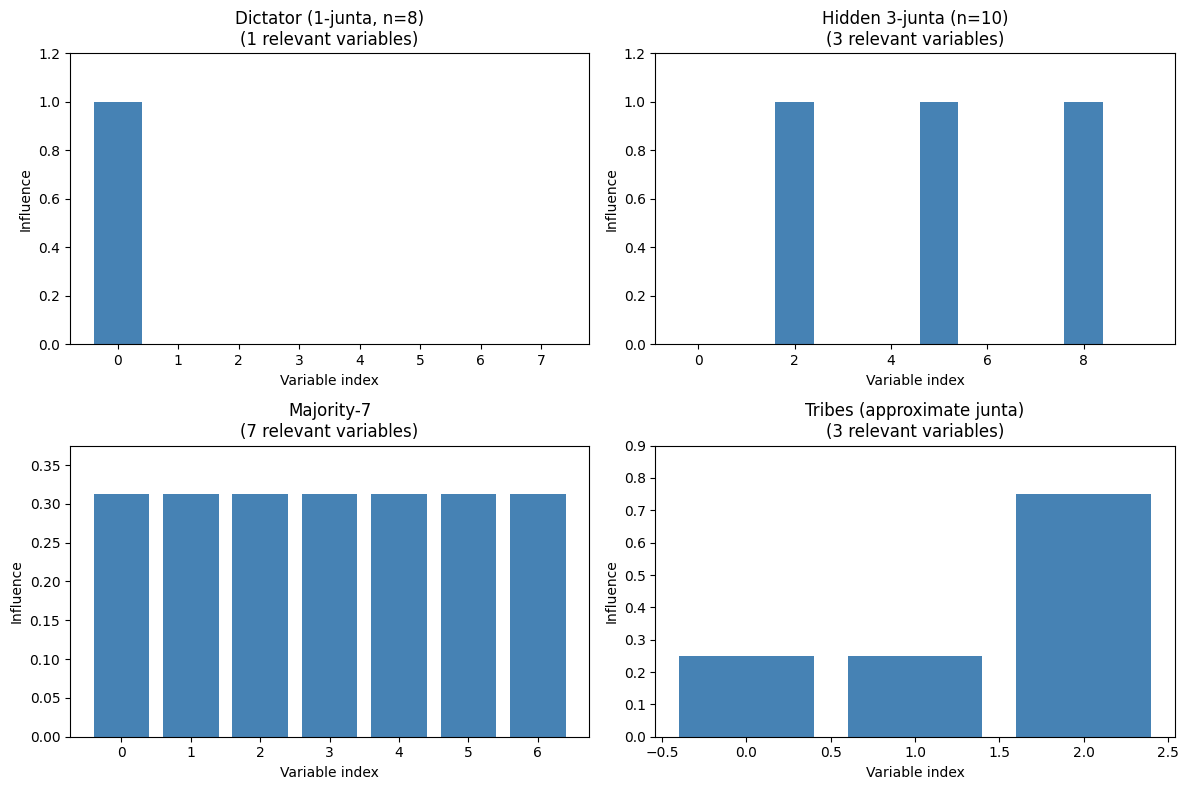

In [11]:
# Visualize influence distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

examples = [
    ("Dictator (1-junta, n=8)", bf.dictator(8, 0)),
    ("Hidden 3-junta (n=10)", hidden_junta),
    ("Majority-7", bf.majority(7)),
    ("Tribes (approximate junta)", bf.tribes(2, 3)),
]

for ax, (name, f) in zip(axes.flat, examples):
    influences = f.influences()
    n_relevant = sum(1 for inf in influences if inf > 1e-10)
    colors = ['steelblue' if inf > 1e-10 else 'lightgray' for inf in influences]
    ax.bar(range(len(influences)), influences, color=colors)
    ax.set_xlabel('Variable index')
    ax.set_ylabel('Influence')
    ax.set_title(f'{name}\n({n_relevant} relevant variables)')
    ax.set_ylim(0, max(influences) * 1.2 if max(influences) > 0 else 1)

plt.tight_layout()
plt.show()

---
## 5. Connection to Goldreich-Levin

From Lecture 7, the **Goldreich-Levin algorithm** finds all "heavy" Fourier coefficients efficiently.

For junta learning:
1. Use Goldreich-Levin to find heavy coefficients
2. The support of heavy coefficients reveals relevant variables
3. Once we know the $k$ relevant variables, we can learn the full function in $2^k$ time

In [12]:
from boofun.analysis.learning import goldreich_levin

print("Using Goldreich-Levin to find junta variables")
print("="*60)

# Find heavy coefficients
heavy = goldreich_levin(hidden_junta, threshold=0.1)

print(f"Hidden 3-junta on variables {{2, 5, 8}}:")
print(f"  Heavy coefficients found: {len(heavy)}")

# Extract relevant variables from heavy coefficients
relevant_vars = set()
for s, coef in heavy:
    bits = [i for i in range(hidden_junta.n_vars) if (s >> i) & 1]
    relevant_vars.update(bits)
    print(f"    S={bits}: {coef:.4f}")

print(f"\n  Inferred relevant variables: {sorted(relevant_vars)}")

Using Goldreich-Levin to find junta variables


Hidden 3-junta on variables {2, 5, 8}:
  Heavy coefficients found: 1
    S=[]: -1.0000

  Inferred relevant variables: []


---
## Summary

| Concept | Description |
|---------|-------------|
| **$k$-Junta** | Function depending on at most $k$ variables |
| **Relevant variable** | Variable $i$ with $\text{Inf}_i[f] > 0$ |
| **Fourier support** | Non-zero $\hat{f}(S)$ only for $S$ within relevant vars |
| **Low-Degree Algo** | $O(n^t)$ if small non-zero coefficient exists |
| **Gaussian Elim** | $O(n^{d\omega})$ based on $\mathbb{F}_2$ degree |
| **[MOS04] Runtime** | $\approx n^{k\omega/(\omega+1)} \approx n^{0.704k}$ |

### boofun API

```python
f.is_junta(k)           # Check if f is a k-junta
f.influences()          # Get per-variable influences
f.total_influence()     # Sum of all influences
goldreich_levin(f, tau) # Find heavy Fourier coefficients
```